# Paper plots

## setup

#### Load packages

In [577]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [578]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [579]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

## load data

In [580]:
AMH = pd.read_csv(os.path.join(csv_dir,"summary/model_human_accuracies.csv"))
AMCK = pd.read_csv(os.path.join(csv_dir,"summary/model_human_CohensK.csv"))
AMRMSE = pd.read_csv(os.path.join(csv_dir,"summary/model_human_pearsonsr_rmse.csv"))
AH = pd.read_csv(os.path.join(csv_dir,"summary/human_accuracy_by_scenario.csv"))
ACK = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCohensKs_by_scenario.csv"))

In [581]:
# # get percentiles for AMRMSE
# AMRMSE = AMRMSE.groupby(['ModelID','scenario']).agg({
#     'Model Kind':'first',
#     'RMSE':['mean',lambda x:np.percentile(x,2.5),lambda x:np.percentile(x,97.5)]
# })

# # get rid of multicols
# AMRMSE.columns = [''.join(col) if type(col) is tuple else col for col in AMRMSE.columns.values]

# AMRMSE.reset_index(inplace=True)

# AMRMSE = AMRMSE.rename(columns={
#     "RMSEmean":"RMSE_mean",
#     "RMSE<lambda_0>":"RMSE_lb",
#     "RMSE<lambda_1>":"RMSE_ub",
#     "Model Kindfirst":"Model Kind"
# })

In [582]:
# merge dataframes
_AMCK = AMCK[["ModelID","scenario","Cohens_k_lb","Cohens_k_med","Cohens_k_ub"]]
# _AMRMSE = AMRMSE[["ModelID","scenario","RMSE_mean","RMSE_lb","RMSE_ub",]]
_AMRMSE = AMRMSE[["ModelID","scenario","RMSE","pearsons_r"]]
MH = pd.merge(AMH,_AMCK,on=['ModelID',"scenario"])
MH = pd.merge(MH,_AMRMSE,on=['ModelID',"scenario"])

In [583]:
SCENARIOS = sorted(MH['scenario'].unique())

In [584]:
#kick out SVG/RPIN additional seeds
MH = MH[~(((MH['Model'] == 'SVG') | (MH['Model'] == 'RPIN')) & (MH['Encoder Training Seed'] != 0.0))]

In [585]:
#choose readout and training type
MH_both = MH[(MH['Readout Type'] == "B") & (MH['Dynamics Training Dataset Type'] == "all")]

In [586]:
MH_readouts = MH[(MH['Dynamics Training Dataset Type'] == "all")]

In [587]:
MH_trainings = MH[(MH['Readout Type'] == "B")].copy()

In [588]:
#collapse model names HACK
MH_trainings['Model Kind'] = MH_trainings['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MH_trainings['Model Kind'] = MH_trainings['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

## Model/human comparision plot

In [589]:
#set up model names
MODELS = dict(MH_both.groupby('Model Kind')['Model'].first())

In [590]:
assert np.all(MH_both.groupby('Model Kind')['ModelID'].count() == 8)

In [591]:
#rename these by hand if necessary
MODELS = {
 'SVG_VGG_0.0_VAE_all_VAE_0_same': 'SVG',
 'OP3_OP3 encoder_0.0_Image Reconstruction_all_Image Reconstruction_0_same': 'OP3',
 'CSWM_CSWM encoder_0.0_Contrastive_all_Contrastive_0_same': 'CSWM',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same': 'RPIN',
 'VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same': 'pVGG-mlp',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same': 'pVGG-lstm',
 'DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_same': 'pDEIT-mlp',
 'DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_same': 'pDEIT-lstm',
 'GNS_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'GNS',
 'GNS-ransac_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'GNS-R',
 'DPI_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'DPI',
}

In [592]:
COLORS = {
    'SVG':'orangered',
    'OP3':'darkorange',
    'CSWM':'gold',
    'RPIN':'greenyellow',
    'pDEIT-lstm':'royalblue',
    'pDEIT-mlp':'blue',
    'pVGG-lstm':'aquamarine',
    'pVGG-mlp':'turquoise',
    'GNS':'slateblue',
    'GNS-R':'orchid',
    'DPI':'hotpink',
}

### Pretty plotting things

In [593]:
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
def marker_from_svg(path):
    path, attributes = svg2paths(path)
    marker = parse_path(attributes[0]['d'])
#     marker = parse_path(path)
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

In [594]:
ICONS = {
     'clothiness':"<",
     'collision':">",
     'containment':"X",
     'dominoes':"p",
     'drop':"d",
     'linking':"h",
     'rollingsliding':"v",
     'towers':"P"
}

In [595]:
svg_dir = os.path.join(proj_dir,"figures/icons/SVG")

ICONS = {
     'clothiness':marker_from_svg(os.path.join(svg_dir,"clothiness.svg")),
     'collision':marker_from_svg(os.path.join(svg_dir,"collision.svg")),
     'containment':marker_from_svg(os.path.join(svg_dir,"containment.svg")),
     'dominoes':marker_from_svg(os.path.join(svg_dir,"dominoes.svg")),
     'drop':marker_from_svg(os.path.join(svg_dir,"drop.svg")),
     'linking':marker_from_svg(os.path.join(svg_dir,"linking.svg")),
     'rollingsliding':marker_from_svg(os.path.join(svg_dir,"rollingsliding.svg")),
     'towers':marker_from_svg(os.path.join(svg_dir,"towers.svg"))
}

In [596]:
#set up color map over models
from matplotlib import cm

cmap = cm.get_cmap('tab20_r')
# cmap = cmap(np.linspace(0, 1, 22))
cmap = cmap.colors

In [597]:
MARKER_SIZE = 20
MEAN_MULTIPLIER = 0.8
ALPHA = 0.2
SCEN_SHIFT = .06
N_ITER = 1000
FIGSIZE = (7,7)

In [598]:
def bootstrap_means(means):
    """Bootstraps over the means across scenarios to generate lower and upper confidence bounds"""
    bootstrapped_means = [np.mean(np.random.choice(means,size=len(AH),replace=True)) for _ in range(N_ITER)]
    lb = np.percentile(bootstrapped_means,2.5)
    ub = np.percentile(bootstrapped_means,97.5)
    mean = np.mean(means)
    boot_mean = np.mean(bootstrapped_means)
    boot_median = np.percentile(bootstrapped_means,50)
    return mean,lb,ub,boot_mean,boot_median

### Accuracy

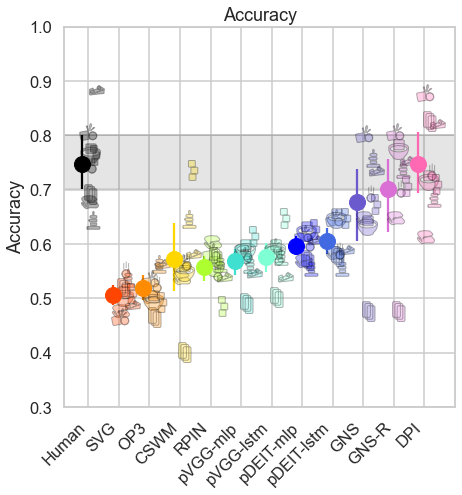

In [599]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AH[AH['scenario']==scenario]['obs_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['model_correct'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=scenario,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['model_correct'])
    axis.errorbar(x+1-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)

#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Accuracy")
axis.set_ylabel("Accuracy")
axis.set_ybound((0.3,1))
plt.savefig(os.path.join(plot_dir,"human_model_accuracy.pdf"),bbox_inches='tight')
plt.show()

### Cohen's $\kappa$

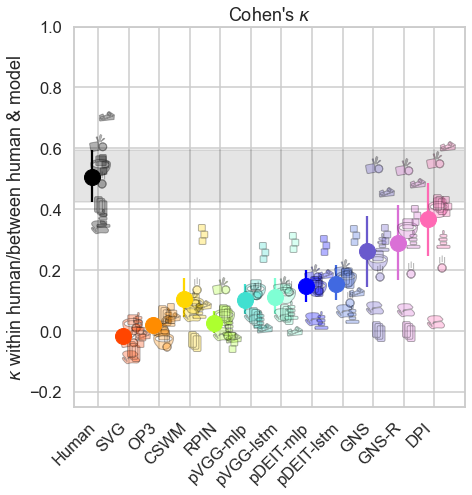

In [600]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(ACK['corr_med'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,ACK[ACK['scenario']==scenario]['corr_med'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['Cohens_k_med'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['Cohens_k_med'])
    axis.errorbar(x+1-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Cohen's $\kappa$")
axis.set_ylabel("$\kappa$ within human/between human & model")
axis.set_ybound((-.25,1))
plt.savefig(os.path.join(plot_dir,"human_model_CohensK.pdf"),bbox_inches='tight')
plt.show()

### Correlation between model & average human

/Users/felixbinder/anaconda3/envs/tdw/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


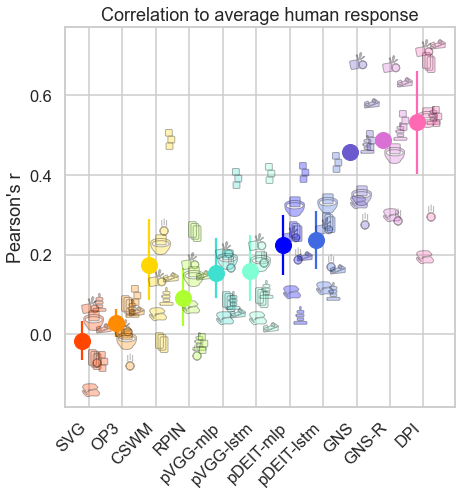

In [601]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
# lb = ACK['corr_lb'].mean()
# ub = ACK['corr_ub'].mean()
# axis.axhspan(lb,ub,
#               color="black",
#                alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
#     axis.plot(0+si*.03,ACK[ACK['scenario']==scenario]['corr_med'],
#               label="Human",
#               marker=ICONS[scenario],
#               fillstyle='full',
# #               markerfacecolor="black",
#               color="black",
#               alpha=.3, 
#               ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['pearsons_r'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
# mean = ACK['corr_med'].mean()
# lb = abs(mean-ACK['corr_lb'].mean())
# ub = abs(mean-ACK['corr_ub'].mean())
# assert ACK['corr_ub'].mean() == ub+mean
# axis.errorbar(0-.2,mean,
#               yerr=([lb],[ub]),
#               label="Human",
#               color="black",
#               marker = "o",
#               ms=MARKER_SIZE*MEAN_MULTIPLIER,
# )
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['pearsons_r'])
    axis.errorbar(x-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)))
axis.set_xticklabels(list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Correlation to average human response")
axis.set_ylabel("Pearson's r")
# axis.set_ybound((0,0.08))
plt.savefig(os.path.join(plot_dir,"human_model_distance.pdf"),bbox_inches='tight')
plt.show()

### Readout type
only vision models

view + simulation is not better than just view

compare B & C on per model basis
paired lines
average across scenario
col: model
    subcol0 C
    subcol1 B
    subcol2 A
y accuracy
color: model

In [602]:
# get the models we have more than one readout type for
readout_models = [m for m,c in (MH_readouts.groupby('Model Kind')['Readout Type'].nunique()).items() if c >= 2]

In [603]:
MODELS_readout = {key:value for key,value in MODELS.items() if key in readout_models}

In [604]:
READOUTS = ["C","B","A"]

READOUT_MARKER = {
    'A': '^',
    'B': 'o',
    'C': 's'
}

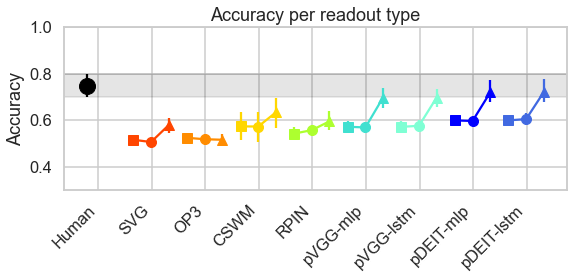

In [605]:
fig, axis = plt.subplots(figsize=(9,3))

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS_readout.items()):
    means = []
    lbs = []
    ubs = []
    for o,readout in enumerate(READOUTS):
        mean,lb,ub,_,_ = bootstrap_means(MH_readouts[(MH_readouts['Model Kind'] == model)&
                                                     (MH_readouts['Readout Type'] == readout)]['model_correct'])
        lb = abs(mean-lb); ub = abs(mean-ub); 
        means.append(mean); lbs.append(lb), ubs.append(ub)
        axis.errorbar(x+.66+0.33 * o,mean,([lb],[ub]),
          marker=READOUT_MARKER[readout],
          color=COLORS[model_name],
          label=model_name,
          ms=10)
    plt.plot([x+.66+0.33 * o for o in range(len(means))],means,color=COLORS[model_name])

#add labels
axis.set_xticks(np.arange(len(MODELS_readout)+1))
axis.set_xticklabels(["Human"] + list(MODELS_readout.values()),rotation=45,ha='right')
axis.set_title("Accuracy per readout type")
axis.set_ylabel("Accuracy")
axis.set_ybound((0.3,1))
plt.savefig(os.path.join(plot_dir,"human_model_readout_accuracy.pdf"),bbox_inches='tight')
plt.show()

### Training Type
do some models generalize better than others? Are any of the scenarios more important to include
points for scenarios
maybe: same as cohens with interconnected lines
or paired barplot with errorbars

or two plots: connected lines
* averaging across scenarios (are some models better at generalizing?)
* are there scenarios that are important to include?

In [606]:
# get the models we have more than one readout type for
trainings_models = [m for m,c in (MH_trainings.groupby('Model Kind')['Dynamics Training Dataset Type'].nunique()).items() if c >= 2]

In [607]:
MODELS_trainings = {key:value for key,value in MODELS.items() if key in trainings_models}

In [608]:
TRAININGS = ["all","all_but_this","same"]

TRAINING_FILL = {
    'all': 'full',
    'all_but_this': 'left',
    'same': 'none'
}

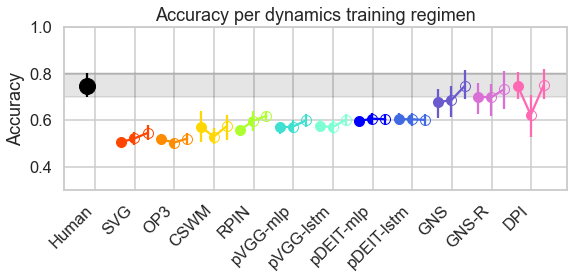

In [609]:
fig, axis = plt.subplots(figsize=(9,3))

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS_trainings.items()):
    means = []
    lbs = []
    ubs = []
    for o,training in enumerate(TRAININGS):
        mean,lb,ub,_,_ = bootstrap_means(MH_trainings[(MH_trainings['Model Kind'] == model)&
                                                     (MH_trainings['Dynamics Training Dataset Type'] == training)]['model_correct'])
        lb = abs(mean-lb); ub = abs(mean-ub); 
        means.append(mean); lbs.append(lb), ubs.append(ub)
        axis.errorbar(x+.66+0.33 * o,mean,([lb],[ub]),
          marker="o",
          fillstyle=TRAINING_FILL[training],
          color=COLORS[model_name],
          label=model_name,
          ms=10)
    plt.plot([x+.66+0.33 * o for o in range(len(means))],means,color=COLORS[model_name])

#add labels
axis.set_xticks(np.arange(len(MODELS_trainings)+1))
axis.set_xticklabels(["Human"] + list(MODELS_trainings.values()),rotation=45,ha='right')
axis.set_title("Accuracy per dynamics training regimen")
axis.set_ylabel("Accuracy")
axis.set_ybound((0.3,1))
plt.savefig(os.path.join(plot_dir,"human_model_training_accuracy.pdf"),bbox_inches='tight')
plt.show()